# Load images data and processing

This tutorial shows how to load and preprocess an image dataset in three ways. 

- First, you will use high-level Keras preprocessing utilities and layers to read a directory of images on disk. 
- Next, you will write your own input pipeline from scratch using tf.data. 
- Finally, you will download a dataset from the large catalog available in TensorFlow Datasets.

## 0. Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


### i. Download the flowers dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
# ~/.keras/datasets/fname in your computer disk.
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


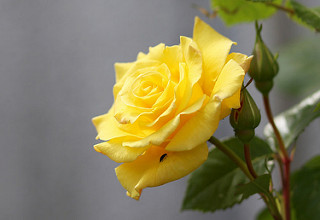

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[42]))

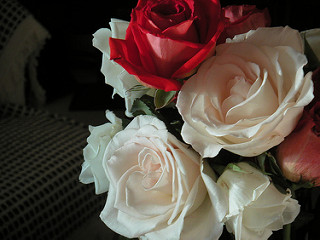

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## 1. Load using keras.preprocessing

### i. Create a dataset

In [6]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# It's good practice to use a validation split when developing your model.
# We will use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# You can find the class names in the class_names attribute on these datasets
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### ii. Visualize the data

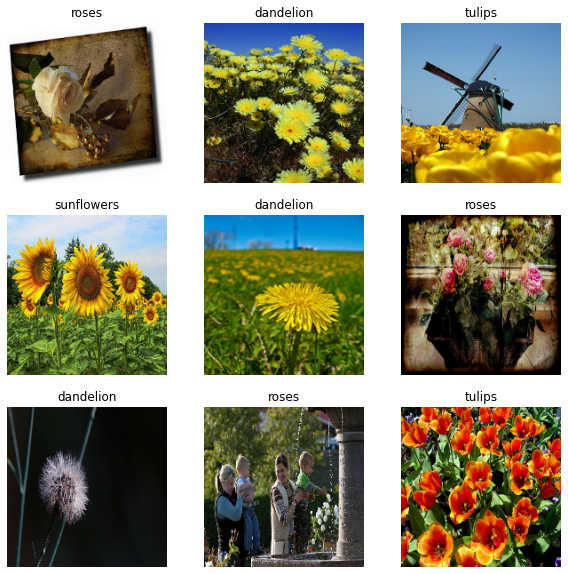

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### iii. Standardize the data

In [12]:
from tensorflow.keras import layers

# [0-255] --> [0-1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print("The minValue: {}\nThe maxValue: {}".format(np.min(first_image), np.max(first_image)))

The minValue: 0.0
The maxValue: 0.9690264463424683


### iv. Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### v. Train a model

In [15]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 9s 69ms/step - loss: 1.4111 - accuracy: 0.4021 - val_loss: 1.1654 - val_accuracy: 0.5599
Epoch 2/3
92/92 [==============================] - 2s 24ms/step - loss: 1.0673 - accuracy: 0.5615 - val_loss: 1.0492 - val_accuracy: 0.5790
Epoch 3/3
92/92 [==============================] - 2s 24ms/step - loss: 0.9092 - accuracy: 0.6492 - val_loss: 0.9355 - val_accuracy: 0.6253


## 2. Using tf.data for finer control

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [19]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\roses\\7551637034_55ae047756_n.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\daisy\\8887005939_b19e8305ee.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\daisy\\14551098743_2842e7a004_n.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\daisy\\144603918_b9de002f60_m.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\daisy\\10994032453_ac7f8d9e2e.jpg'


In [20]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [21]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [23]:
# Write a short function that converts a file path to an (img, label) pair:

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [24]:
# Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### i. Configure dataset for performance

In [25]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### ii. Visualize the data

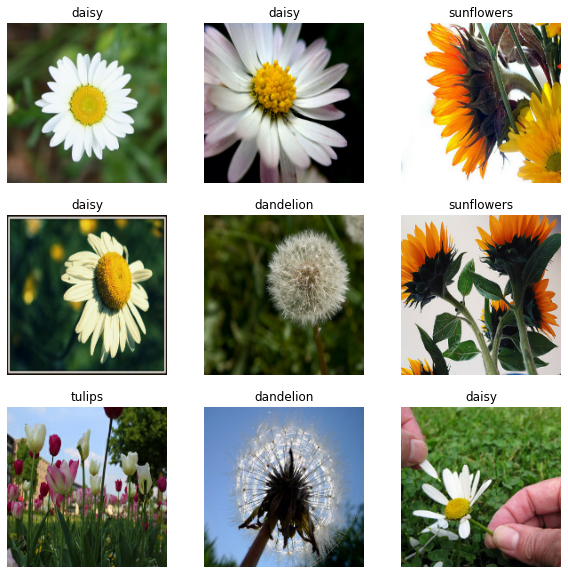

In [26]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### iii. Continue training the model

In [27]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 3s 32ms/step - loss: 0.7631 - accuracy: 0.7153 - val_loss: 0.8360 - val_accuracy: 0.6608
Epoch 2/3
92/92 [==============================] - 2s 27ms/step - loss: 0.5807 - accuracy: 0.7905 - val_loss: 0.8783 - val_accuracy: 0.6975
Epoch 3/3
92/92 [==============================] - 2s 26ms/step - loss: 0.4009 - accuracy: 0.8624 - val_loss: 0.8735 - val_accuracy: 0.6757


## 3. Using TensorFlow Datasets

# reference

### https://tensorflow.google.cn/tutorials/load_data/images